In [1]:
import hana_ml
print(hana_ml.__version__)

2.15.23021701


In [2]:
from hana_ml import dataframe
from hana_ml.dataframe import ConnectionContext

conn = dataframe.ConnectionContext(address="XXXX.hana.prod-XXXX.hanacloud.ondemand.com", port =443, user = "DEMO#PYTHON")

In [3]:
df_remote = conn.sql('select * from "CPM_DEMO_202111"."TK_GasolinePrices_Covid19"')
df_remote.count()

606

In [4]:
from hdbcli import dbapi
dbapi_cursor = conn.connection.cursor()

if conn.sql("SELECT TABLE_OID FROM SYS.TABLES WHERE TABLE_NAME = 'GASOLINEPRICE_FORECASTS_SEGMENTED';").count() > 0:
   dbapi_cursor.execute("""TRUNCATE TABLE GASOLINEPRICE_FORECASTS_SEGMENTED;""")

In [5]:
# In this example, one time-series is shown. So, the state includes only "Baden-Württemberg"
df_remote_segment = conn.sql('SELECT * FROM "CPM_DEMO_202111"."TK_GasolinePrices_Covid19"' )
    
# Sort data ascending, a requirement of the Automated Predictive Library
df_remote_segment = df_remote_segment.sort("DATE", desc = False)
# Check the last day in training data set, namely 2021-10-21
# Therefore, the forecasting shall starts with 2021-10-22
df_remote_segment.collect().tail(5)


,DATE,STATE,DIESEL,E5,E10,DIESELCHANGE,E5CHANGE,E10CHANGE,Meldedatum,NewCase,TotalCase,RecoveredCase
601,2021-10-17,Baden-Württemberg,1.575046,1.734676,1.663572,0.768175,0.831795,0.826853,2021-10-17,0,500,497
602,2021-10-18,Baden-Württemberg,1.576613,1.733893,1.663404,0.751059,0.816909,0.811743,2021-10-18,0,1118,1094
603,2021-10-19,Baden-Württemberg,1.582585,1.741076,1.670355,0.748168,0.825459,0.819143,2021-10-19,0,3348,3323
604,2021-10-20,Baden-Württemberg,1.579843,1.730955,1.660201,0.730919,0.819382,0.81374,2021-10-20,0,3144,3125
605,2021-10-21,Baden-Württemberg,1.581192,1.732241,1.661466,0.744473,0.825713,0.819729,2021-10-21,0,2845,2828


In [6]:

import pandas as pd
columns = ["SEGMENT", "MAPE"]
df_allmapes = pd.DataFrame(columns=columns)


In [7]:

# Import HANA-APL library
from hana_ml.algorithms.apl.time_series import AutoTimeSeries
# Forecast next 7 days --> Super E5, based on column "DATE"
tsapl = AutoTimeSeries(time_column_name = 'DATE', target = 'E5', horizon = 7)
tsapl.fit(data = df_remote_segment)

In [8]:
from hana_ml.dataframe import DataFrame
# Extra-predictable variables' values on the forecast period
forecast_df = DataFrame(conn,
                      'SELECT * '
                      'from "CPM_DEMO_202111"."TK_GasolinePrices_Covid19"'
                      'WHERE "E5" is null LIMIT 7')

df_remote_aplforecast = tsapl.forecast(data= forecast_df)


In [9]:

# Check the next 7 days forecasting
df_remote_aplforecast_next7 = df_remote_aplforecast.collect().tail(7)
df_remote_aplforecast_next7 


,DATE,ACTUAL,PREDICTED,LOWER_INT_95PCT,UPPER_INT_95PCT
606,2021-10-22,NaN,1.732406,1.730088,1.734724
607,2021-10-23,NaN,1.732554,1.730010,1.735097
608,2021-10-24,NaN,1.732652,1.729917,1.735387
609,2021-10-25,NaN,1.732587,1.729678,1.735497
610,2021-10-26,NaN,1.732543,1.729470,1.735616
611,2021-10-27,NaN,1.732563,1.729334,1.735792
612,2021-10-28,NaN,1.732564,1.729168,1.735960


In [10]:

# Write the forecasting results in the target table of SAP Data Warehouse Cloud
segment_bw = 'Baden-Württemberg'
df_remote_aplforecast = df_remote_aplforecast.select('*', ("'" + segment_bw + "'", 'SEGMENT'))
df_remote_aplforecast = df_remote_aplforecast.cast("SEGMENT", "NVARCHAR(100)") # Needed to ensure future segments with longer names can be stored
df_remote_aplforecast.save("GASOLINEPRICE_FORECASTS_SEGMENTED", append = True)

In [11]:
# Track model quality
ts_mape = tsapl.get_performance_metrics()['MAPE'][0]
df_allmapes = df_allmapes.append({"SEGMENT": segment_bw, "MAPE": ts_mape}, ignore_index=True)


/Users/vishwa/Library/Python/3.9/lib/python/site-packages/hana_ml/algorithms/apl/time_series.py:901: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  ret = {metric_name: [val for _, val in vals.iteritems()]
/var/folders/mg/phh0t0n96ndg9y12t2rshdm80000gn/T/ipykernel_80906/3461141853.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_allmapes = df_allmapes.append({"SEGMENT": segment_bw, "MAPE": ts_mape}, ignore_index=True)


In [12]:
df_allmapes

,SEGMENT,MAPE
0,Baden-Württemberg,0.000583


Fontconfig warning: ignoring UTF-8: not a valid region tag


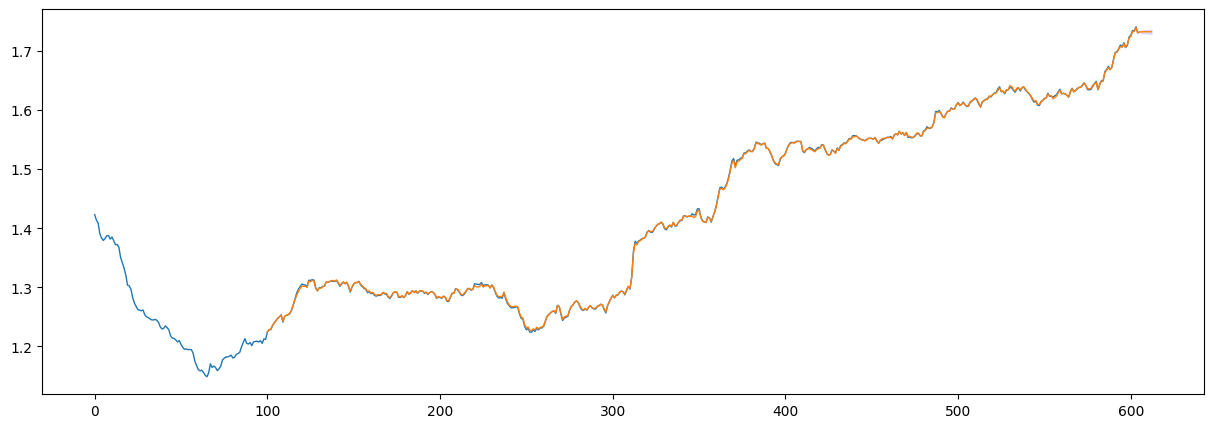

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
df_remote = conn.sql("SELECT * FROM GASOLINEPRICE_FORECASTS_SEGMENTED WHERE SEGMENT ='Baden-Württemberg'")
ts_data = df_remote.collect()
plt.figure(figsize=(15, 5))
plt.plot(ts_data["ACTUAL"], linewidth=1)
plt.plot(ts_data["PREDICTED"], linewidth=1)
plt.fill_between( ts_data.index, ts_data["LOWER_INT_95PCT"], ts_data["UPPER_INT_95PCT"], color='b', alpha=.1);